<a href="https://colab.research.google.com/github/tmj1432/Capstone-Deep-Learning-/blob/main/Capstone_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capstone : Phase 1 

**Problem Statement**

Research shows that 60% of customers will stop doing business with a brand after just one poor customer service experience. Additionally, when it comes to reviews, the fact is that people are more likely to share their bad reviews than their good ones. However, most of these lost customers could have been retained had the problem been resolved or by providing service recovery before it is too late. 

Today, I will be building a deep learning model that will help identify angry customers so that businesses will be able to take action to appease and provide service recovery to these angry customers before they leave the establishment.

---

**Success Metric**

As we are building a model for the use in the customer service industry, it would mean that being able to **correctly identify angry customers** is important. With the ability to identify such customers, establishments are able to **provide service recovery before it is too late**

In this notebook, we are looking to achieve **greater than 80% recall for Angry Faces**.

As recall is the fraction of positive instances that are correctly predicted by the classifier, we want as many correctly predicted angry faces as possible. This is due to the fact that there are **more consequences of not being able to identify angry faces**. 

--- 

In this notebook, we will be building our own custom CNN model using a dataset consisting pictures of my own face. This model will be trained on four facial expressions (Angry, Sad, Neutral and Happy). 

---

## Mount Google Drive

In [1]:
 from google.colab import drive
 
 drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---

## Import Libraries

In [3]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf
import cv2
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import activations
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import keras.backend as K
import keras_tuner

---

## Visualising Dataset

As mentioned earlier, we are using a dataset with my own facial expressions taken with my iPhone. **The dataset consists of about 150 photos for each facial expression.**

### Function to Crop Face

As pictures are taken from my iPhone, it is not grayscaled or cropped at my face. The function below helps to grayscale and crop pictures. 

---

**Reason for cropping face**

The reason why I cropped the face only is to **reduce image noise**. Noise can distract the model and make it harder to recognize patterns in the data. By removing noise from the images, it can help the model focus on the important features and patterns it needs to learn. Overall, reducing image noise can help improve the performance and generalization ability of a CNN model by eliminating distractions and improving the signal-to-noise ratio in the data.

---

**Benefits of applying grayscale**

1) It **reduces the amount of data the model needs to process**. Grayscale images have only one channel (compared to three channels for a color image), which means they are smaller and require less memory and computational resources to process. This can be especially beneficial if you are working with large datasets or if you are training on hardware with limited resources.

2) It can **simplify the model and make it easier to train**. Using grayscale images can reduce the complexity of the model, which can make it easier to train and debug.

3) It can **improve the generalization ability of the model**. By removing the color information from the images, you are forcing the model to rely on other features (such as shape, texture, and edges) to recognize patterns in the data. This can help the model learn more generalizable features and perform better on new, unseen data.

---

In [5]:
def detectFaceOpenCVHaar(framepath, inHeight=300, inWidth=0):
    frame = cv2.imread(framepath)
    frameOpenCVHaar = frame.copy()
    frameHeight = frameOpenCVHaar.shape[0]
    frameWidth = frameOpenCVHaar.shape[1]
    if not inWidth:
        inWidth = int((frameWidth / frameHeight) * inHeight)

    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth

    frameOpenCVHaarSmall = cv2.resize(frameOpenCVHaar, (inWidth, inHeight))
    frameGray = cv2.cvtColor(frameOpenCVHaarSmall, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(frameGray)
    bboxes = []
    for (x, y, w, h) in faces:
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y + h
        cvRect = [int(x1 * scaleWidth), int(y1 * scaleHeight),
                  int(x2 * scaleWidth), int(y2 * scaleHeight)]
        bboxes.append(cvRect)
        cv2.rectangle(frameOpenCVHaar, (cvRect[0], cvRect[1]), (cvRect[2], cvRect[3]), (0, 255, 0),
                      int(round(frameHeight / 150)), 4)
      
    cropped_image = frameOpenCVHaar[cvRect[1]:cvRect[3], cvRect[0]:cvRect[2]]
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    return cropped_image

### Function to Plot Images

In [6]:
def img_show(path):
  # apply predefined crop function
  cropped = detectFaceOpenCVHaar(path)  
  plt.imshow(cropped, cmap="gray", vmin=0, vmax=255)

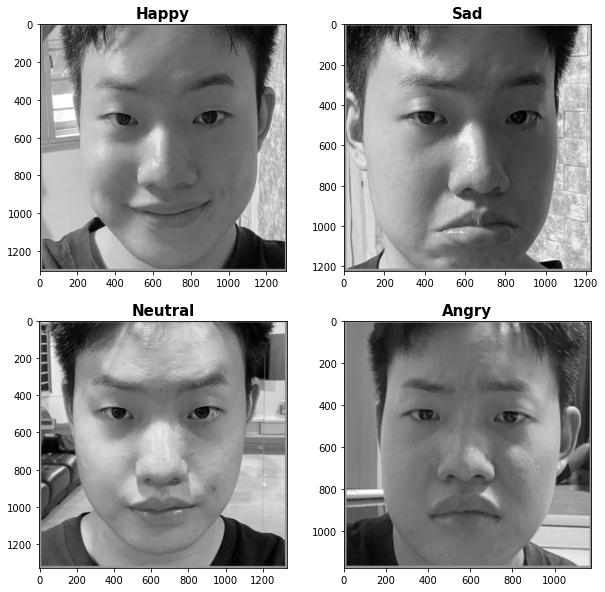

In [7]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/happy/IMG_9468.JPG')
plt.title('Happy', fontsize=15, fontweight='bold')

plt.subplot(2,2,2)
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/sad/IMG_9847.JPG')
plt.title('Sad', fontsize=15, fontweight='bold')

plt.subplot(2,2,3)
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/neutral/IMG_0656.JPG')
plt.title('Neutral', fontsize=15, fontweight='bold')

plt.subplot(2,2,4)
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/angry/IMG_0001.JPG')
plt.title('Angry', fontsize=15, fontweight='bold');

The plot above visualises the four emotions we will be training our model with in this notebook.

---

## Image Pre-processing

In order for our model to interpret images, we have to process them accordingly.

### Function to create Image Data

Here we are using a custom function to create our train-val and test data.
This function applies our face crop function and resize them before converting them into an array.

In [8]:
def create_image_data(data,img_size, datadirectory, classes):
    for category in classes:
        path = os.path.join(datadirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
              #function to crop face and grayscale
                img_array = detectFaceOpenCVHaar(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                data.append([new_array,class_num])
            except Exception as e:
                pass

In [9]:
# classes in dataset
classes = ['angry','happy','neutral','sad']

### Create Train and Test Array

In [10]:
# read all the images and convert them to array
training_data = [] 

# path
datadirectory_train = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train' 

# using pre-defined function 
create_image_data(training_data, 224, datadirectory_train, classes)

In [11]:
# shuffle training data 
random.Random(42).shuffle(training_data)

Shuffling the training data can help improve the generalization ability and efficiency of our model

### Train-Val Split

In [14]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

In [15]:
# X forms the training images, and y forms the training labels
X = np.array(X)

y = to_categorical(y)

In [16]:
# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalisation

In [19]:
# Each image's dimension is 224 x 224
img_rows, img_cols = 224, 224
# The input shape of a neural network refers to the dimensions of the input data that the network expects to receive.
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

### Image Augmentation

**Benefits of Image Augmentation**

1) It can **increase the size of the training dataset**, which can help the model learn more effectively.

2) It can **help the model generalize better to new, unseen data**. By generating a diverse set of training examples through image augmentation, the model can learn to recognize patterns and features that are invariant to transformations such as translation, rotation, and scaling.

3) It can **help the model learn more robust features**. By applying transformations to the training data, the model can learn to recognize patterns and features that are invariant to these transformations, which can make the model more robust and less sensitive to variations in the data.

4) It can **help reduce overfitting**. By generating a larger and more diverse training dataset through image augmentation, the model may be less likely to overfit to the specific characteristics of the training data.

### Visualising Image Augmentation

Let us visualise the image augmentation on one picture. 

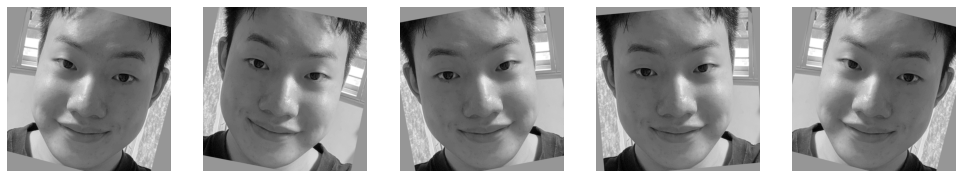

In [20]:

#Loads in image path
img = detectFaceOpenCVHaar('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/happy/IMG_9468.JPG')
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#Uses ImageDataGenerator to flip the images
datagen = ImageDataGenerator(horizontal_flip=True,rotation_range=15)
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(17,17))
#Plots our figures
for i in range(1,6):
  plt.subplot(1, 5, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_[:,:,0], cmap="gray", vmin=0, vmax=255)
  plt.axis('off')

We chose horizontal flip as it is not realistic for a person's face to be filmed upside down while horizontal flip allows the model to learn from different angles of the face. And rotation range of 15 helps to increase variation of the pictures to help increase generalizability of the model.

### Apply Image Augmentation

In [21]:
gen = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=15)

batches = gen.flow(X_train, y_train, batch_size=32)
val_batches = gen.flow(X_val, y_val, batch_size=32)

**To summarize this section**

Firstly, we applied our pre-defined function to crop and grayscale images from the original dataset and convert them into an array.

Secondly, we applied train-val split to our training data for modeling and prepared our test data.

Thirdly, we applied image augmentation to our image data.

Lastly, normalized our data by dividing it by 255.



---

## Modeling

### Convolutional Neural Networks

A convolutional neural network is a type of artificial neural network specifically designed for processing data that has a grid-like topology, such as an image. CNNs are particularly useful for image classification.

In a CNN, the input data is processed through multiple layers of interconnected nodes, each of which performs a specific operation on the data.

The layers of a CNN can include **convolutional layers**, **pooling layers**, and **fully connected layers**. Convolutional layers apply a set of filters to the input data, pooling layers reduce the dimensionality of the data, and fully connected layers learn a non-linear mapping between the input and output data.

---
**Convolution**

Convolution is performed by applying a set of filters (also known as kernels or weights) to the input data and computing the dot product between the filter and a small region of the input data.

Convolution is typically applied in a sliding window fashion, where the filters are moved across the input data in a predetermined step size (the stride). At each position, the dot product between the filter and the region of the input data is computed and output as a single value. This process is repeated for all positions in the input data, resulting in a set of output values that form a new, filtered version of the input data.

**Convolutional Layers**

We will be experimenting between two models with varying numbers of convolutional layers. Ultimately, the best way for us to determine the optimal number of convolutional layers for our model is to try out different configurations and see which one performs best on our dataset.

---
**Pooling**

Pooling is a technique that is commonly used in convolutional neural networks (CNNs) to down-sample the spatial dimensions of the data and extract more robust features from the data.

**Max Pooling**

In max pooling, the maximum value within each region of the input data is selected and output as the pooled value.

Max pooling is used due to its ability to preserve the most important features in the data and suppress noise or less important features. 

This can be particularly useful for tasks such as facial emotion recognition, where the features of interest (e.g., facial features, facial expressions) may be more variable or less well-defined.

---

**Dropout**

Dropout is a **regularization technique** that is often used in neural networks to reduce overfitting and improve generalization performance. In a neural network, dropout works by randomly setting a certain percentage of the neurons in a layer to zero during training, which forces the network to rely on the remaining neurons and can prevent the network from relying too heavily on any one neuron or feature.

---

**Flatten**

The flatten operation is used to **convert the multidimensional output of the convolutional and pooling layers into a one-dimensional array** that can be fed into the fully connected (dense) layers.

---

**Dense Layer**

A dense layer (also known as a fully connected layer) is a type of **layer in a neural network that is composed of neurons that are connected to all the neurons in the previous layer**. In a dense layer, each neuron receives input from all the neurons in the previous layer, and each neuron provides output to all the neurons in the next layer.

Dense layers are often used in convolutional neural networks (CNNs) to learn a non-linear mapping between the input and output data. They are typically placed after one or more convolutional or pooling layers, which have already extracted features from the input data.

---

### Compiling

Compiling a convolutional neural network (CNN) refers to the process of configuring the CNN for training. During the compilation process, you specify the loss function and optimizer that the CNN will use during training.

**Loss Function**

The loss function is a measure of how well the CNN is performing on the training data. It is used to calculate the error between the predicted output of the CNN and the true output, and to guide the optimization process. The loss function we are using is categorical cross-entropy for our classification task.

**Optimizer**

The optimizer is an algorithm that is used to update the weights of the CNN during training. It determines how the CNN will adjust its weights to reduce the loss and improve its performance on the training data.

**Metrics**

The metrics parameter specifies a list of metrics to track during training and evaluation.

---

### Callback

**Early Stopping**

Early stopping allows you to terminate the training process if the model's performance on a validation dataset stops improving. This can **help you to avoid overfitting**, where the model begins to memorize the training data rather than learning generalizable features.

**Model Checkpoint**

Model checkpointing is a technique used to save the state of a neural network during training. It allows you to save the model at regular intervals or at specific points during training, such as after completing a certain number of epochs or after achieving a certain level of accuracy.

**Learning Rate Scheduling**

Learning rate scheduling is a technique used to adjust the learning rate of a neural network during training. It can help the network converge faster and achieve better performance by adapting the learning rate to the specific characteristics of the training data.

In [22]:
early_stopping = EarlyStopping(monitor='loss', patience=3)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint_model1 = ModelCheckpoint('model1_phase1.h5', verbose=1, save_best_only=True)

model_checkpoint_model2 = ModelCheckpoint('model2_phase1.h5', verbose=1, save_best_only=True)

# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [23]:
# number of possible predictions output
num_classes = 4

### Function for Plotting Training Curves

In [24]:
def plot_training_curves(history,model_name):
  plt.figure(figsize=(16,8))

  plt.subplot(2,2,1)
  plt.plot(history.history['accuracy'], label='Train accuracy')
  plt.plot(history.history['val_accuracy'], label='Val accuracy')
  plt.legend()
  plt.title(f'{model_name} (Accuracy)', fontweight='bold', fontsize=10)

  plt.subplot(2,2,2)
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.legend()
  plt.title(f'{model_name} (Loss)', fontweight='bold', fontsize=10);

### Model 1 : Baseline

In [25]:
model1 = Sequential()

# Add convolutional layers
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same')) # input shape defined in one of the cells above
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2)))

# Flatten the output and add fully connected layers
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

# Compile the model
model1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [26]:
history_1 = model1.fit(batches,
           batch_size=32,
           epochs=20,
           validation_data=val_batches,
           validation_steps=len(X_train)/32,
           use_multiprocessing=True,
           callbacks=[early_stopping, model_checkpoint_model1,lr_scheduler])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.7436 - accuracy: 0.2854
Epoch 1: val_loss improved from inf to 1.38538, saving model to model1_phase1.h5
16/16 [==============================] - 36s 2s/step - loss: 2.7436 - accuracy: 0.2854 - val_loss: 1.3854 - val_accuracy: 0.2910 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 1.3858 - accuracy: 0.2815
Epoch 2: val_loss improved from 1.38538 to 1.36363, saving model to model1_phase1.h5
16/16 [==============================] - 36s 2s/step - loss: 1.3858 - accuracy: 0.2815 - val_loss: 1.3636 - val_accuracy: 0.3281 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 1.3761 - accuracy: 0.3031
Epoch 3: val_loss did not improve from 1.36363
16/16 [==============================] - 34s 2s/step - loss: 1.3761 - accuracy: 0.3031 - val_loss: 1.3710 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 1.3464 - ac

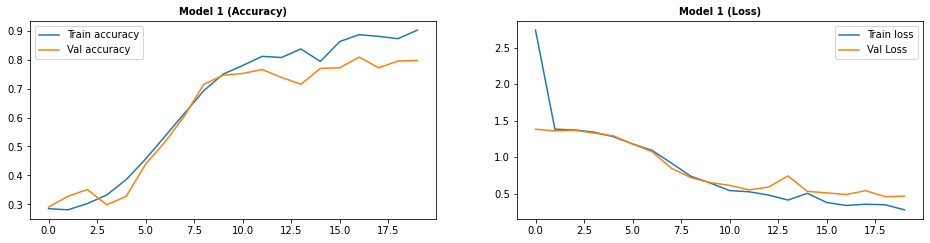

In [27]:
plot_training_curves(history_1,'Model 1')

Currently, the difference between the train and test accuracy is greater than 0.1 which shows that it is overfitting.

Additionally, based on the learning curves we can see that there is some **overfitting** where there is a big gap between the train and val accuracy. This trend was also shown on the loss function where there is a gap between train and val loss.


### Model 2 : Adding Dropout Layers

In order to improve from Model 1, we will be implementing dropout which will help **regularize and reduce overfitting**.

In [28]:
model2 = Sequential()

# Add convolutional layers
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same')) # input shape defined in one of the cells above
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))


# Flatten the output and add fully connected layers
model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

# Compile the model
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [29]:
history_2 = model2.fit(batches,
           batch_size=32,
           epochs=20,
           validation_data=val_batches,
           validation_steps=len(X_train)/32,
           use_multiprocessing=True,
           callbacks=[early_stopping, model_checkpoint_model2, lr_scheduler])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.3859 - accuracy: 0.2894
Epoch 1: val_loss improved from inf to 1.37073, saving model to model2_phase1.h5
16/16 [==============================] - 39s 2s/step - loss: 2.3859 - accuracy: 0.2894 - val_loss: 1.3707 - val_accuracy: 0.3281 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 1.3790 - accuracy: 0.2756
Epoch 2: val_loss improved from 1.37073 to 1.35939, saving model to model2_phase1.h5
16/16 [==============================] - 39s 2s/step - loss: 1.3790 - accuracy: 0.2756 - val_loss: 1.3594 - val_accuracy: 0.3672 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 1.2967 - accuracy: 0.3622
Epoch 3: val_loss improved from 1.35939 to 1.18550, saving model to model2_phase1.h5
16/16 [==============================] - 39s 2s/step - loss: 1.2967 - accuracy: 0.3622 - val_loss: 1.1855 - val_accuracy: 0.4863 - lr: 0.0010
Epoch 4/20
16/16 [=======================

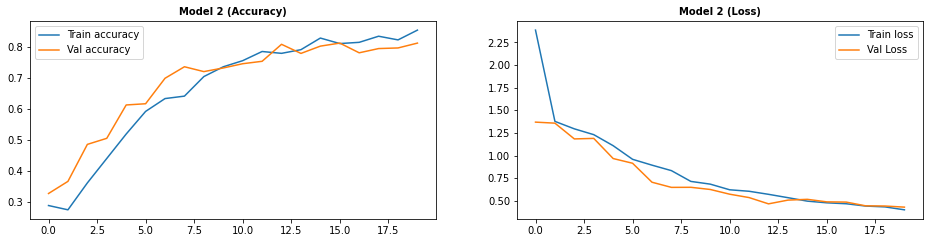

In [30]:
plot_training_curves(history_2,'Model 2')

Based on the learning curves, we can see that there is a smaller gap between the train and the val curves on both the accuracy and the loss function. This shows that our regularisation techniques has helped us to get a better fit. 

By **reducing overfitting, we can improve the generalizability** of our model, as it is more likely to make accurate predictions on new, unseen data.

### Model 3 : Tune the model architecture



KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search. Easily configure your search space with a define-by-run syntax, then leverage one of the available search algorithms to find the best hyperparameter values for your models.

In [31]:
def build_model(hp):
  model = Sequential()

  # Add convolutional layers
  model.add(Conv2D(hp.Choice('units', [16, 32, 64, 128]),
                    kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(224, 224, 1)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(hp.Choice('units', [16, 32, 64, 128]),
                    kernel_size=(3, 3),
                    activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))


  # Flatten the output and add fully connected layers
  model.add(Flatten())

  model.add(Dense(hp.Choice('units', [16, 32, 64, 128]), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))

  # Compile the model
  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
  return model

In [32]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [33]:
tuner.search(batches, epochs=5, validation_data=(val_batches))
best_model = tuner.get_best_models()[0]

Trial 4 Complete [00h 04m 07s]
val_loss: 1.0763936042785645

Best val_loss So Far: 1.0763936042785645
Total elapsed time: 00h 17m 12s


### Tuning Summary

In [36]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 64
Score: 1.0763936042785645
Trial summary
Hyperparameters:
units: 128
Score: 1.1717524528503418
Trial summary
Hyperparameters:
units: 32
Score: 1.2456660270690918
Trial summary
Hyperparameters:
units: 16
Score: 1.3817859888076782


We can see that 64units gave us the best model

### Retrain the model

In [37]:
# instantiate modelcheckpoint for this model
model_checkpoint_model3 = ModelCheckpoint('model3_phase1.h5', verbose=1, save_best_only=True)

In [40]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model3 = build_model(best_hps[0])
# Fit with the entire dataset.
history3 = model3.fit(batches,
           batch_size=32,
           epochs=40,
           validation_data=val_batches,
           validation_steps=len(X_train)/32,
           use_multiprocessing=True,
           callbacks=[early_stopping, model_checkpoint_model3, lr_scheduler])

Epoch 1/40
16/16 [==============================] - ETA: 0s - loss: 1.9436 - accuracy: 0.2854
Epoch 1: val_loss improved from inf to 1.38418, saving model to model3_phase1.h5
16/16 [==============================] - 64s 4s/step - loss: 1.9436 - accuracy: 0.2854 - val_loss: 1.3842 - val_accuracy: 0.3359 - lr: 0.0010
Epoch 2/40
16/16 [==============================] - ETA: 0s - loss: 1.3721 - accuracy: 0.3307
Epoch 2: val_loss improved from 1.38418 to 1.33217, saving model to model3_phase1.h5
16/16 [==============================] - 58s 4s/step - loss: 1.3721 - accuracy: 0.3307 - val_loss: 1.3322 - val_accuracy: 0.4043 - lr: 0.0010
Epoch 3/40
16/16 [==============================] - ETA: 0s - loss: 1.2741 - accuracy: 0.4114
Epoch 3: val_loss improved from 1.33217 to 1.23179, saving model to model3_phase1.h5
16/16 [==============================] - 56s 3s/step - loss: 1.2741 - accuracy: 0.4114 - val_loss: 1.2318 - val_accuracy: 0.4746 - lr: 0.0010
Epoch 4/40
16/16 [=======================

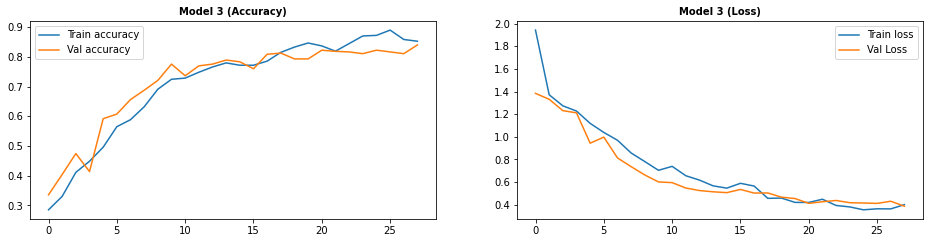

In [43]:
plot_training_curves(history3,'Model 3')

We can see that the train and test curves closely follows each other which means that it is a good fit. And after tuning the model, we managed to get a better model than before.

---

Let us move to the next notebook for model evaluation.

---